In [1]:
!which python
!which pip

/home/anton/Work/interviews/aspose/venv/bin/python
/home/anton/Work/interviews/aspose/venv/bin/pip


In [94]:
!pip install tqdm

## Imports

In [1]:
import fasttext
import fasttext.util
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from itertools import combinations
from typing import List, Dict
import numpy as np
import re
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
import networkx as nx
from nltk.corpus import stopwords
import json
import tensorflow as tf
from rouge import Rouge
import tensorflow_datasets as tfds
from tqdm import tqdm

nltk.download('all')
stopwords = set(stopwords.words('english'))


2021-08-11 21:11:41.821949: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/anton/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/anton/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /home/anton/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /home/anton/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /home/anton/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     /

[nltk_data]    |   Package udhr is already up-to-date!
[nltk_data]    | Downloading package udhr2 to /home/anton/nltk_data...
[nltk_data]    |   Package udhr2 is already up-to-date!
[nltk_data]    | Downloading package unicode_samples to
[nltk_data]    |     /home/anton/nltk_data...
[nltk_data]    |   Package unicode_samples is already up-to-date!
[nltk_data]    | Downloading package universal_treebanks_v20 to
[nltk_data]    |     /home/anton/nltk_data...
[nltk_data]    |   Package universal_treebanks_v20 is already up-to-
[nltk_data]    |       date!
[nltk_data]    | Downloading package verbnet to
[nltk_data]    |     /home/anton/nltk_data...
[nltk_data]    |   Package verbnet is already up-to-date!
[nltk_data]    | Downloading package verbnet3 to
[nltk_data]    |     /home/anton/nltk_data...
[nltk_data]    |   Package verbnet3 is already up-to-date!
[nltk_data]    | Downloading package webtext to
[nltk_data]    |     /home/anton/nltk_data...
[nltk_data]    |   Package webtext is alre

## Summarization metrics
BLEU and ROUGE

#### BLEU


In [2]:


# Downloading
fasttext.util.download_model('en', if_exists='ignore')
fasttext.util.download_model('ru', if_exists='ignore')

ft_en = fasttext.load_model('cc.en.300.bin')
ft_ru = fasttext.load_model('cc.ru.300.bin')

print(ft_en.get_dimension())
print(ft_ru.get_dimension())

300
300


In [3]:
ft_en

In [19]:
text = """
Одной из областей применения обработки естественного языка является
суммаризация текстов, подразумевающая создание краткой версии текста, документа,
статьи с помощью машинного обучения. Есть два вида суммаризации: абстрактная или
генерирующая, когда на основе существующего текста модель создает новый текст
меньшего объема, как правило в исходном тексте представленный лишь частично, и
экстрактная или извлекающая, когда модель ранжирует предложения, фразы или
абзацы в тексте и отбирает заданное пользователем число наиболее важных
элементов, при этом идут они в той же последовательности, что и в оригинальном
тексте, из-за чего как правило нарушается связность результата.
В качестве тестового задания предлагается реализовать последний подход для
суммаризации текстов, как требующий меньше времени и ресурсов.
"""

In [46]:
sentence = text_to_sentences(text)[0]

In [55]:
vec = sentence_to_vec(sentence, ft_ru)

In [59]:
cosine_similarity(np.array([1, 0]).reshape(1, -1), np.array([0, 1]).reshape(1, -1))

array([[0.]])

In [60]:
np.array([1, 0]).reshape(1, -1)

array([[1, 0]])

In [52]:
print(*combinations(range(4), 2), sep='\n')

(0, 1)
(0, 2)
(0, 3)
(1, 2)
(1, 3)
(2, 3)


In [73]:
# news = """
# Третья волна коронавируса быстрее распространяется из-за новых вариантов COVID-19, сообщил глава Минздрава Михаил Мурашко.
# Он назвал эту волну более агрессивной.
# «Третья волна, она в силу того, что меняется штамм, более агрессивна и быстрее распространяется среди населения»,— сказал господин Мурашко в ходе рабочей поездки в Астрахань (цитата по ТАСС).
# Министр отметил, что дельта-штамм более заразен, при заболевании сокращается инкубационный период и время до развития тяжелых осложнений.
# По его словам, часто «уже на пятые сутки формируются грозные тяжелые осложнения».
# Михаил Мурашко призвал заболевших обращаться к врачу «фактические в первые сутки», чтобы получить лекарство и начать терапию.
# «Тогда исходы позволяют нам держаться обычных стандартных показателей»,— добавил он.
# Роспотребнадзор считает, что для борьбы с новыми мутациями нужна ревакцинация раз в полгода.
# Ведомство отмечало, что эффект вакцин против дельта-штамма снижается.
# Вместе с тем Всемирная организация здравоохранения призывает ввести временный мораторий на ревакцинацию. 
# """


news = """
Тегеран не подтверждает информацию о причастности к нападению на танкер-химовоз Mercer Street в Аравийском море.
Об этом заявил глава пресс-службы вооруженных сил Ирана Аболфазл Шекарчи.
«Если бы нам пришлось противостоять врагам... Мы бы объявили об этом открыто, поэтому недавнее заявление врагов — это психологическая операция»,— сказал господин Шекарчи, комментируя совместное заявление стран G7 о причастности Тегерана к нападению на танкер (цитата по Reuters).
Накануне страны G7 выпустили совместное заявление, в котором утверждается, что Иран причастен к нападению 30 июля на танкер Mercer Street в Аравийском море, который следовал под флагом Либерии.
Инцидент произошел в 280 км от побережья Омана.
В результате погибли два члена экипажа судна — гражданин Румынии и подданный Великобритании.
Лондон и Вашингтон заявили, что ведут консультации с союзниками, чтобы дать согласованный ответ на нападение.
"""

sentences = text_to_sentences(news)
vecs = [sentence_to_vec(s, ft_ru) for s in sentences]
matrix = get_similarity_matrix(vecs)

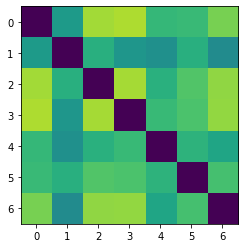

In [74]:
plt.imshow(matrix, vmin=0, vmax=1)

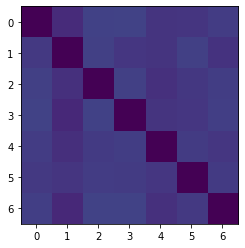

In [75]:
plt.imshow(matrix / matrix.sum(0)[:, None], vmin=0, vmax=1)

In [88]:
def textrank(m: np.ndarray, d: float = 0.85, iterations: int = 100, init_value: float = 40) -> np.ndarray:
#     assert 0. < init_value <= 1., f"Initial value must be in interval (0, 1]"
    assert m.shape[0] == m.shape[1], f"Similarity matrix must be square"
    assert iterations > 0, f"Iterations count must be "
    ranks = np.full((m.shape[0],), fill_value=init_value)
    print(ranks)
    
#     di = m.sum(0)
#     dm = m / di[:, None]
#     dm = m / ()
#     print(dm)
    
    for iteration in range(iterations):
        ranks = (1 - d) + d * np.dot(m, ranks)
#         new_ranks = ranks.copy()
#         for i in range(len(ranks)):
# #             new_ranks[i] = ranks[i] * (1 - d) + d * ((ranks * m[i]).sum())
#             new_ranks[i] = (1 - d) + d * ((ranks * dm[i]).sum())
#         ranks = new_ranks
        print(ranks)
    return ranks

In [89]:
ranks = textrank(matrix)
print(ranks)
# nx_graph = nx.from_numpy_array(matrix)
# scores = nx.pagerank(nx_graph)

[40 40 40 40 40 40 40]
[150.4198313  112.87925526 155.17651942 153.03441527 126.43737259
 139.78975072 144.3353556 ]
[529.54698895 409.32703482 541.0276969  537.27181738 454.18016088
 492.86542395 513.8334758 ]
[1873.82529014 1443.77821284 1919.01851402 1902.22449702 1603.21422617
 1745.36076915 1813.635577  ]
[6627.68536448 5108.56802474 6783.8918333  6727.31622838 5672.20169481
 6171.7505484  6418.1822918 ]
[23441.57197674 18067.48201892 23996.90350631 23794.61648283
 20061.3231014  21830.21468672 22698.14398733]
[82911.21006533 63903.95126632 84873.18838823 84159.38068392
 70955.76657794 77210.9649855  80283.45798644]
[293249.7784026  226022.32631772 300190.81912743 297664.87762922
 250964.27778882 273089.1967524  283954.45523446]
[1037199.60565773  799421.96079785 1061748.18149787 1052815.10109715
  887639.32874775  965892.78807596 1004323.64856014]
[3668485.77126547 2827486.49794839 3755312.97365624 3723716.71025737
 3139503.949962   3416280.05959453 3552205.77305449]
[12975118.86

In [58]:
scores.items()

dict_items([(0, 0.1517488912087936), (1, 0.11871791422061005), (2, 0.15602764876042094), (3, 0.1540501923781136), (4, 0.1306368876737971), (5, 0.1425194999362859), (6, 0.14629896582197882)])

In [61]:
a = np.arange(25).reshape(5, 5)

In [93]:
sorted(list(scores.items()), key=lambda x: x[1], reverse=True)

[(2, 0.15602764876042094),
 (3, 0.1540501923781136),
 (0, 0.1517488912087936),
 (6, 0.14629896582197882),
 (5, 0.1425194999362859),
 (4, 0.1306368876737971),
 (1, 0.11871791422061005)]

In [63]:
b = np.array([4, 9, 14, 19, 24])
b

array([ 4,  9, 14, 19, 24])

In [64]:
a / b[:, None]

array([[0.        , 0.25      , 0.5       , 0.75      , 1.        ],
       [0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ],
       [0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ],
       [0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ],
       [0.83333333, 0.875     , 0.91666667, 0.95833333, 1.        ]])

In [3]:
class SingleLangSummarizer:
    
    def __init__(self, word2vec, remove_stopwords=False, lemmatize=False):
        self.word2vec = word2vec
        self.remove_stopwords = remove_stopwords
        self.lemmatize = lemmatize
        
    def _text_to_sentences(self, text: str) -> List[str]:
        return sent_tokenize(text.replace('\n', ' ').strip())
    
    def _sentence_to_vec(self, sentence: str) -> np.ndarray:
        vec = np.zeros((self.word2vec.get_dimension(),), dtype=np.float32)
        res = re.sub(r'[^\w\s]', '', sentence)
        words = word_tokenize(sentence)
        for word in words:
#             if self.remove_stopwords and word not in stopwords:
#                 vec += self.word2vec.get_word_vector(word)
            vec += self.word2vec.get_word_vector(word)
        return vec / len(words)
    
    def _get_similarity_matrix(self, sentences) -> np.ndarray:
        matrix = np.zeros((len(sentences), len(sentences)), dtype=np.float32)
        for i, j in combinations(range(len(sentences)), 2):
            similarity = cosine_similarity(sentences[i].reshape(1, -1), sentences[j].reshape(1, -1))
            matrix[i][j] = matrix[j][i] = similarity  
        return matrix
        
    def summarize(self, text: str, k: int) -> str:
        sentences = self._text_to_sentences(text)
#         print('debug: sentences:')
#         print(*sentences, sep='\n')
        vecs = [self._sentence_to_vec(s) for s in sentences]
        matrix = self._get_similarity_matrix(vecs)
        nx_graph = nx.from_numpy_array(matrix)
        scores = nx.pagerank(nx_graph)
        sorted_scores = sorted(list(scores.items()), key=lambda x: x[1], reverse=True)[:k]
        result_idxs = [e[0] for e in sorted(sorted_scores, key=lambda x: x[0])]
        result = ' '.join(sentences[i] for i in result_idxs)
        return result

In [120]:
summarizer = SingleLangSummarizer(ft_ru)
print(summarizer.summarize(news, 3))

Тегеран не подтверждает информацию о причастности к нападению на танкер-химовоз Mercer Street в Аравийском море. «Если бы нам пришлось противостоять врагам... Мы бы объявили об этом открыто, поэтому недавнее заявление врагов — это психологическая операция»,— сказал господин Шекарчи, комментируя совместное заявление стран G7 о причастности Тегерана к нападению на танкер (цитата по Reuters). Накануне страны G7 выпустили совместное заявление, в котором утверждается, что Иран причастен к нападению 30 июля на танкер Mercer Street в Аравийском море, который следовал под флагом Либерии.


In [3]:
scitldr_testset = '/home/anton/Work/interviews/aspose/datasets/scitldr-master/SciTLDR-Data/SciTLDR-FullText/test.jsonl'
with open(scitldr_testset, 'r') as fp:
    lines = fp.readlines()

In [126]:
lines[0]

'{"source": ["Incremental class learning involves sequentially learning classes in bursts of examples from the same class.", "This violates the assumptions that underlie  methods for training standard deep neural networks, and will cause them to suffer from catastrophic forgetting.", "Arguably, the best method for incremental class learning is iCaRL, but it requires storing  training examples for each class, making it challenging to scale.", "Here, we propose FearNet for incremental class learning.", "FearNet is a generative model that does not store previous examples, making it memory efficient.", "FearNet uses a brain-inspired dual-memory system in which new memories are consolidated from a network for recent memories inspired by the mammalian hippocampal complex to a network for long-term storage inspired by medial prefrontal cortex.", "Memory consolidation is inspired by mechanisms that occur during sleep.", "FearNet also uses a module inspired by the basolateral amygdala for deter

In [5]:
test_sample = json.loads(lines[0])
test_sample

{'source': ['Incremental class learning involves sequentially learning classes in bursts of examples from the same class.',
  'This violates the assumptions that underlie  methods for training standard deep neural networks, and will cause them to suffer from catastrophic forgetting.',
  'Arguably, the best method for incremental class learning is iCaRL, but it requires storing  training examples for each class, making it challenging to scale.',
  'Here, we propose FearNet for incremental class learning.',
  'FearNet is a generative model that does not store previous examples, making it memory efficient.',
  'FearNet uses a brain-inspired dual-memory system in which new memories are consolidated from a network for recent memories inspired by the mammalian hippocampal complex to a network for long-term storage inspired by medial prefrontal cortex.',
  'Memory consolidation is inspired by mechanisms that occur during sleep.',
  'FearNet also uses a module inspired by the basolateral amygd

In [6]:
for target_sample in test_sample['target']:
    if target_sample in test_sample['source']:
        print(target_sample)

In [19]:
summarizer = SingleLangSummarizer(ft_en)
print(summarizer.summarize(' '.join(test_sample['source']), 2))

Incremental class learning involves sequentially learning classes in bursts of examples from the same class. This violates the assumptions that underlie  methods for training standard deep neural networks, and will cause them to suffer from catastrophic forgetting.


In [3]:
flask==2.0.1
flask_socketio==5.1.1
simple-websocket==0.3.0

2021-08-11 13:55:17.627847: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [15]:
ds

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/287113 [00:00<?, ? examples/s]

Shuffling cnn_dailymail-train.tfrecord...:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/13368 [00:00<?, ? examples/s]

Shuffling cnn_dailymail-validation.tfrecord...:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/11490 [00:00<?, ? examples/s]

Shuffling cnn_dailymail-test.tfrecord...:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /home/anton/tensorflow_datasets/cnn_dailymail/3.1.0. Subsequent calls will reuse this data.


2021-08-11 14:10:22.544657: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-11 14:10:22.582802: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-11 14:10:22.583235: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3080 Laptop GPU computeCapability: 8.6
coreClock: 1.245GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 357.69GiB/s
2021-08-11 14:10:22.583254: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-11 14:10:22.600636: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-11 14:10:22.600674: I tensorflow/stream_

{Split('train'): <PrefetchDataset shapes: {article: (), highlights: ()}, types: {article: tf.string, highlights: tf.string}>,
 Split('validation'): <PrefetchDataset shapes: {article: (), highlights: ()}, types: {article: tf.string, highlights: tf.string}>,
 Split('test'): <PrefetchDataset shapes: {article: (), highlights: ()}, types: {article: tf.string, highlights: tf.string}>}

In [58]:
# test_dataset = tf.data.Dataset.from_tensor_slices(list(ds['test']))
print(train_list[1]['article'].numpy().decode('utf-8'))
print('---------')
print(train_list[1]['highlights'].numpy().decode('utf-8'))

(CNN) -- Ralph Mata was an internal affairs lieutenant for the Miami-Dade Police Department, working in the division that investigates allegations of wrongdoing by cops. Outside the office, authorities allege that the 45-year-old longtime officer worked with a drug trafficking organization to help plan a murder plot and get guns. A criminal complaint unsealed in U.S. District Court in New Jersey Tuesday accuses Mata, also known as "The Milk Man," of using his role as a police officer to help the drug trafficking organization in exchange for money and gifts, including a Rolex watch. In one instance, the complaint alleges, Mata arranged to pay two assassins to kill rival drug dealers. The killers would pose as cops, pulling over their targets before shooting them, according to the complaint. "Ultimately, the (organization) decided not to move forward with the murder plot, but Mata still received a payment for setting up the meetings," federal prosecutors said in a statement. The complain

debug: sentences:
(CNN) -- Ralph Mata was an internal affairs lieutenant for the Miami-Dade Police Department, working in the division that investigates allegations of wrongdoing by cops.
Outside the office, authorities allege that the 45-year-old longtime officer worked with a drug trafficking organization to help plan a murder plot and get guns.
A criminal complaint unsealed in U.S. District Court in New Jersey Tuesday accuses Mata, also known as "The Milk Man," of using his role as a police officer to help the drug trafficking organization in exchange for money and gifts, including a Rolex watch.
In one instance, the complaint alleges, Mata arranged to pay two assassins to kill rival drug dealers.
The killers would pose as cops, pulling over their targets before shooting them, according to the complaint.
"Ultimately, the (organization) decided not to move forward with the murder plot, but Mata still received a payment for setting up the meetings," federal prosecutors said in a state

'A criminal complaint unsealed in U.S. District Court in New Jersey Tuesday accuses Mata, also known as "The Milk Man," of using his role as a police officer to help the drug trafficking organization in exchange for money and gifts, including a Rolex watch. "Ultimately, the (organization) decided not to move forward with the murder plot, but Mata still received a payment for setting up the meetings," federal prosecutors said in a statement. Mata has worked for the Miami-Dade Police Department since 1992, including directing investigations in Miami Gardens and working as a lieutenant in the K-9 unit at Miami International Airport, according to the complaint.'

In [61]:
rouge = Rouge()

In [71]:
text_0 = train_list[0]
hyp0 = summarizer.summarize(text_0['article'].numpy().decode('utf-8'), k=3)
ref0 = text_0['highlights'].numpy().decode('utf-8')
print('-' * 50)
print(hyp0)
print('-' * 50)
print(ref0)
rouge.get_scores(hyp0, ref0)

debug: sentences:
By .
Associated Press .
PUBLISHED: .
14:11 EST, 25 October 2013 .
| .
UPDATED: .
15:36 EST, 25 October 2013 .
The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October.
The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion.
Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A .
State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure.
The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A.
The diocese says he contracted the infection through contaminated food while attending a conference fo

[{'rouge-1': {'r': 0.6060606060606061,
   'p': 0.46511627906976744,
   'f': 0.5263157845602493},
  'rouge-2': {'r': 0.3939393939393939, 'p': 0.25, 'f': 0.3058823481910035},
  'rouge-l': {'r': 0.5757575757575758,
   'p': 0.4418604651162791,
   'f': 0.4999999950865652}}]

In [68]:
text_1 = train_list[1]
hyp1 = summarizer.summarize(text_1['article'].numpy().decode('utf-8'), k=3)
ref1 = text_1['highlights'].numpy().decode('utf-8')
rouge.get_scores(hyp1, ref1)

debug: sentences:
(CNN) -- Ralph Mata was an internal affairs lieutenant for the Miami-Dade Police Department, working in the division that investigates allegations of wrongdoing by cops.
Outside the office, authorities allege that the 45-year-old longtime officer worked with a drug trafficking organization to help plan a murder plot and get guns.
A criminal complaint unsealed in U.S. District Court in New Jersey Tuesday accuses Mata, also known as "The Milk Man," of using his role as a police officer to help the drug trafficking organization in exchange for money and gifts, including a Rolex watch.
In one instance, the complaint alleges, Mata arranged to pay two assassins to kill rival drug dealers.
The killers would pose as cops, pulling over their targets before shooting them, according to the complaint.
"Ultimately, the (organization) decided not to move forward with the murder plot, but Mata still received a payment for setting up the meetings," federal prosecutors said in a state

[{'rouge-1': {'r': 0.3333333333333333,
   'p': 0.13580246913580246,
   'f': 0.19298245202677755},
  'rouge-2': {'r': 0.11764705882352941,
   'p': 0.0380952380952381,
   'f': 0.057553953139071724},
  'rouge-l': {'r': 0.3333333333333333,
   'p': 0.13580246913580246,
   'f': 0.19298245202677755}}]

In [70]:
rouge.get_scores([hyp0, hyp1], [ref0, ref1], avg=True)

{'rouge-1': {'r': 0.4696969696969697,
  'p': 0.30045937410278495,
  'f': 0.3596491182935134},
 'rouge-2': {'r': 0.2557932263814617,
  'p': 0.14404761904761904,
  'f': 0.18171815066503763},
 'rouge-l': {'r': 0.4545454545454546,
  'p': 0.2888314671260408,
  'f': 0.3464912235566714}}

## Evaluating SingleLangSummarizer (no stopwords removal, no lemmatizing) with FastText english model on cnn_dailymail

### Train

In [4]:
# Getting dataset
ds, ds_info = tfds.load('cnn_dailymail', with_info=True)
ds

2021-08-11 15:55:49.668946: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-11 15:55:49.724397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-11 15:55:49.725135: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3080 Laptop GPU computeCapability: 8.6
coreClock: 1.245GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 357.69GiB/s
2021-08-11 15:55:49.725195: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-11 15:55:49.745866: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-11 15:55:49.745954: I tensorflow/stream_

{'train': <PrefetchDataset shapes: {article: (), highlights: ()}, types: {article: tf.string, highlights: tf.string}>,
 'validation': <PrefetchDataset shapes: {article: (), highlights: ()}, types: {article: tf.string, highlights: tf.string}>,
 'test': <PrefetchDataset shapes: {article: (), highlights: ()}, types: {article: tf.string, highlights: tf.string}>}

In [10]:
# Initializing rouge
rouge = Rouge()

In [5]:
# Initializing summarizer
summarizer = SingleLangSummarizer(ft_en)

In [11]:
# Defining function for evaluation
def evaluate_cnn_dailymail(summarizer, data, k: int = 3):
    hyps, refs = [], []
    for sample in tqdm(data):
        text = sample['article'].numpy().decode('utf-8')
        ref = sample['highlights'].numpy().decode('utf-8')
        hyp = summarizer.summarize(text, k)
        hyps.append(hyp)
        refs.append(ref)
    print(json.dumps(rouge.get_scores(hyps, refs, avg=True), indent=4))

In [7]:
# Train
evaluate_cnn_dailymail(summarizer, list(ds['train']))

2021-08-11 15:55:57.209068: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-11 15:55:57.228297: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2199995000 Hz
  1%|▋                                                                       | 2772/287113 [07:43<13:11:35,  5.99it/s]


KeyboardInterrupt: 

In [8]:
# Validation
val = list(ds['validation'])
len(val)

13368

In [12]:
evaluate_cnn_dailymail(summarizer, val)

100%|███████████████████████████████████████████████████████████████████████████| 13368/13368 [26:40<00:00,  8.35it/s]


{
    "rouge-1": {
        "r": 0.34489054437451205,
        "p": 0.22542288039598582,
        "f": 0.26357269051841586
    },
    "rouge-2": {
        "r": 0.10720480599459638,
        "p": 0.065581516534886,
        "f": 0.07804714178094152
    },
    "rouge-l": {
        "r": 0.310961474565765,
        "p": 0.2031631889617812,
        "f": 0.2375559584110965
    }
}


In [13]:
# Test
test = list(ds['test'])
len(test)

11490

In [16]:
evaluate_cnn_dailymail(summarizer, test)

100%|███████████████████████████████████████████████████████████████████████████| 11490/11490 [23:22<00:00,  8.19it/s]


{
    "rouge-1": {
        "r": 0.34512175359695446,
        "p": 0.21787056480942532,
        "f": 0.25846525347495475
    },
    "rouge-2": {
        "r": 0.1057098270264606,
        "p": 0.062296011345463614,
        "f": 0.07507965718344696
    },
    "rouge-l": {
        "r": 0.31091823545802955,
        "p": 0.1962828177921399,
        "f": 0.23280499034968744
    }
}
